# Описание проекта

Необходимо построить модель, которая предскажет температуру стали перед процессом разливки.

В распоряжении имеются данные о сплаве на разных этапах обработки.


## Исследовательский анализ данных

### Импорт библиотек

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as ltb
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler 

### Чтение файлов

In [31]:
data_arc = pd.read_csv('...')
data_bulk = pd.read_csv('...')
data_bulk_time = pd.read_csv('...')
data_gas = pd.read_csv('...')
data_temp = pd.read_csv('...')
data_wire = pd.read_csv('...')
data_wire_time = pd.read_csv('...)

### Данные об электродах

In [32]:
data_arc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


In [33]:
data_arc.head(19)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
5,2,2019-05-03 11:34:14,2019-05-03 11:36:31,0.438063,0.283043
6,2,2019-05-03 11:38:50,2019-05-03 11:44:28,1.296415,0.892914
7,2,2019-05-03 11:46:19,2019-05-03 11:48:25,0.490377,0.305281
8,2,2019-05-03 11:49:48,2019-05-03 11:53:18,0.827743,0.516874
9,3,2019-05-03 12:06:54,2019-05-03 12:11:34,1.062053,0.671494


**Вывод** 

Пропусков в данных нет. Единственное, что нужно сделать - привести дату к типу datetime. Формат записи часа - 24 часа.

In [34]:
data_arc['Начало нагрева дугой'] = pd.to_datetime(data_arc['Начало нагрева дугой'], format='%Y-%m-%d %H:%M:%S')
data_arc['Конец нагрева дугой'] = pd.to_datetime(data_arc['Конец нагрева дугой'], format='%Y-%m-%d %H:%M:%S')

Исследуем числовые значения на выбросы и адекватность. 

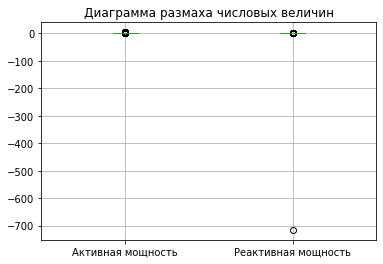

In [35]:
plt.title('Диаграмма размаха числовых величин')
data_arc[['Активная мощность', 'Реактивная мощность']].boxplot()
plt.show()

**Вывод**

Отрицательная реактивная мощность - подозрительное значение, удалим эти данные из рассмотрения.

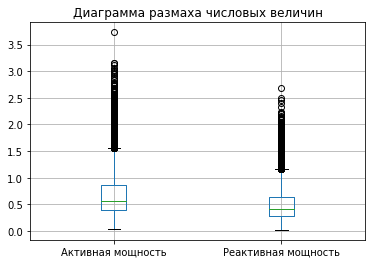

In [36]:
data_arc = data_arc[data_arc['Реактивная мощность'] > 0]
plt.title('Диаграмма размаха числовых величин')
data_arc[['Активная мощность', 'Реактивная мощность']].boxplot()
plt.show()


### Данные о сыпучих материалах

In [37]:
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [38]:
data_bulk.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


**Вывод**

Столбцы в датафрейме - сыпучие материалы, которые возможно добавить в сталь. Пропуски в датафрейме - не ошибки. Они говорят о том, что данный материал не добавлялся в выбранную партию стали. 


In [39]:
data_bulk['key'].tail()

3124    3237
3125    3238
3126    3239
3127    3240
3128    3241
Name: key, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

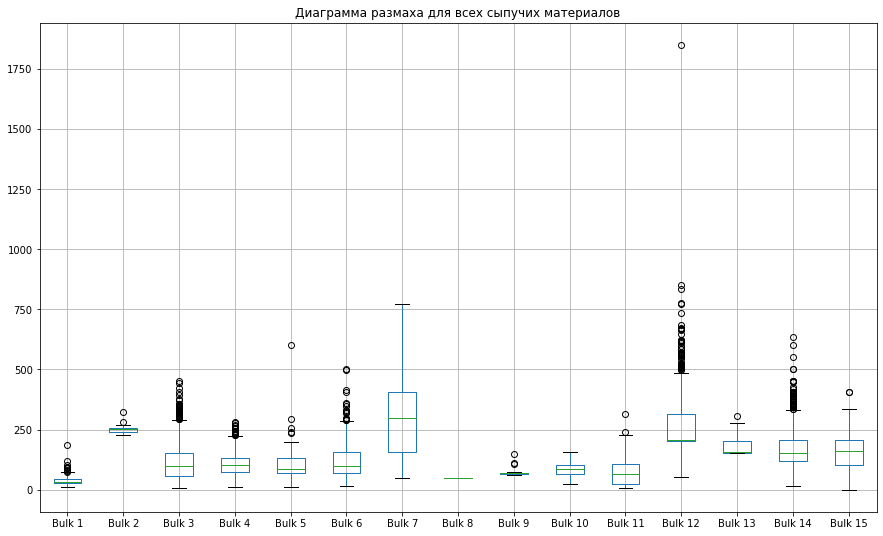

In [40]:
plt.figure(figsize=(15,9))
plt.title('Диаграмма размаха для всех сыпучих материалов')
data_bulk.drop('key', axis=1).boxplot()
plt.show

In [41]:
data_bulk = data_bulk.fillna(0)
data_bulk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   3129 non-null   float64
 2   Bulk 2   3129 non-null   float64
 3   Bulk 3   3129 non-null   float64
 4   Bulk 4   3129 non-null   float64
 5   Bulk 5   3129 non-null   float64
 6   Bulk 6   3129 non-null   float64
 7   Bulk 7   3129 non-null   float64
 8   Bulk 8   3129 non-null   float64
 9   Bulk 9   3129 non-null   float64
 10  Bulk 10  3129 non-null   float64
 11  Bulk 11  3129 non-null   float64
 12  Bulk 12  3129 non-null   float64
 13  Bulk 13  3129 non-null   float64
 14  Bulk 14  3129 non-null   float64
 15  Bulk 15  3129 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


In [42]:
data_bulk[data_bulk['Bulk 8'] > 0]

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1725,1786,0.0,0.0,123.0,0.0,0.0,0.0,0.0,49.0,147.0,0.0,0.0,0.0,0.0,0.0,0.0


**Вывод**

Сыпучий материал №8 использовался всего лишь в одной партии. Материал № 5 и № 12 имеют ярко выраженные выбросы, что это: был заказ редкий сплав или это ошибки технологов производства? 

In [43]:
data_bulk_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


In [44]:
data_bulk_time.head(5)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


**Вывод**

Ситуация с датафреймом с временем подачи сыпучих материалов идентичная. Единственная разница - необходимость перевести дату в тип datetime.

In [45]:
for i in range(1,16):
    data_bulk_time[f'Bulk {i}'] = pd.to_datetime(data_bulk_time[f'Bulk {i}'], format='%Y-%m-%d %H:%M:%S') 

### Данные о проволочных материалах

In [46]:
data_wire.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


In [47]:
data_wire_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


In [48]:
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Исследуем, приходилось ли несколько раз добавлять проволоку в какую-нибудь из партий.

In [49]:
data_wire['key'].value_counts().unique()

array([1])

**Вывод**

Во все партии проволока добавлялась только 1 раз.

In [50]:
data_wire_time.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Вывод**

Ситуация с датафреймами с информацией о подаче проволоки идентичная. Здесь также есть необходимость перевести дату из "data_wire_time" в тип datetime.

In [51]:
for i in range(1,10):
    data_wire_time[f'Wire {i}'] = pd.to_datetime(data_wire_time[f'Wire {i}'], format='%Y-%m-%d %H:%M:%S') 

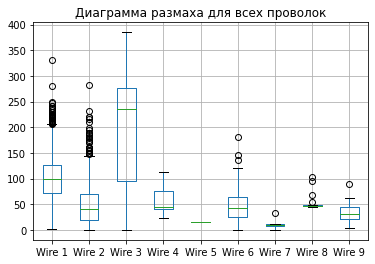

In [52]:
plt.title('Диаграмма размаха для всех проволок')
data_wire.drop('key',axis=1).boxplot()
plt.show()


In [53]:
data_wire=data_wire.fillna(0)
data_wire.head()

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Вывод**

Диаграммы размаза у проволок получились различные, однако, из всех выделяется проволока №5.

In [54]:
data_wire[data_wire['Wire 5'] > 0]

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
2440,2567,18.30192,0.0,96.288193,0.0,15.132,73.307526,0.0,0.0,0.0


**Вывод**

Сталь с добавлением проволоки № 5 - редкий зверь.

### Данные о продувке сплава газом

In [55]:
data_gas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


In [56]:
data_gas.tail()

,key,Газ 1
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103
3238,3241,12.680959


,Газ 1
count,3239.000000
mean,11.002062
std,6.220327
min,0.008399
25%,7.043089
50%,9.836267
75%,13.769915
max,77.995040


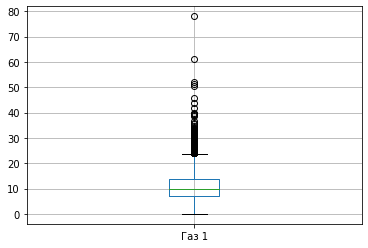

In [57]:
data_gas.drop('key',axis=1).boxplot()
display(data_gas.drop('key',axis=1).describe())
a = data_gas.drop('key',axis=1).describe()

**Вывод**

Данные о газе пропусков не содержат. Выбросы в распределении - рабочие значения для редких сплавов.

### Данные о температуре

In [58]:
data_temp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [59]:
data_temp.head(12)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
5,2,2019-05-03 11:37:27,1581.0
6,2,2019-05-03 11:38:00,1577.0
7,2,2019-05-03 11:49:38,1589.0
8,2,2019-05-03 11:55:50,1604.0
9,2,2019-05-03 11:58:24,1608.0


**Вывод**

В данных о замере температуры есть пропуски, от которых стоит избавиться.

In [60]:
omission = data_temp[data_temp['Температура'].isna() == True]['key'].unique()
data_temp = data_temp.query('key not in @omission')
data_temp.head()

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


In [61]:
a = data_temp['key'].value_counts()
alone = a[a == 1].index
data_temp = data_temp.query('key not in @alone')

## Список уточняющих вопросов

1. Какого качества предсказания мне необходимо добиться и на какой метрике?
2. Есть ли ограничения на скорость построения предсказаний? Критична ли ресурсоёмкость?
3. В описании к заданию говорится о том, что температура измеряется перед добавлением легирующих материалов, однако, если посмотреть на время первого замера в партии №1 и №3, то оно говорит о том, что замеры были проведены после добавления сыпучего материала № 12,14,15. Считать это неточностью описания задачи или датафреймы о сыпучих материалах и проволоке содержали пропуски добавления легантов?
4. Сыпучие материалы № 5 и 12 имеют выбросы, это связано с тем, что изготовлялся какой-то редкий сплав или это была ошибка технологов?
4. Правильно ли я понимаю, что последний замер температуры в партии и есть наш целевой признак? 

## План работы

1. Уточнение образовавшихся вопросов.
2. Предварительная обработка данных: удаление ненужных пропусков, неадекватных значений.
3. Подготовка датафрейма с признаками, которые объективно влияют на температуру расплава. Разбиение его на выборки (обучающую, валидационную и тестовую)
4. Определение модели МО с лучшей метрикой качества предсказания. 
5. Написание вывода и отчёта.

### Создание датафрейма с признаками и целевым признаком


In [62]:
dk = pd.concat([data_arc['key'],
                data_arc['Конец нагрева дугой'] - data_arc['Начало нагрева дугой']], axis=1, keys=['key', 'Время нагрева'])
# создаём отдельный датафрейм с номерами партии и разностью времён между концом и началом нагрева

all_time_heat = dk.pivot_table(index='key', values='Время нагрева', aggfunc='sum') / np.timedelta64(1, 's') # сводная таблица,
# в которой данные сгруппированы по партиям, а интересующая нас величина - суммарное время нагрева партии в секундах

heat_count = data_arc.pivot_table(index='key', values = 'Активная мощность', aggfunc='count')
heat_count.rename(columns={'Активная мощность': 'Количество запусков нагрева'}, inplace=True)

powers = data_arc.pivot_table(index='key', values=['Активная мощность','Реактивная мощность'], aggfunc='sum')
data_heat = all_time_heat.merge(powers, on='key')
data_heat = data_heat.merge(heat_count, on='key')
data_heat['Энергия'] = np.sqrt((data_heat['Активная мощность'] ** 2 )) * data_heat['Время нагрева']
data_heat

,Время нагрева,Активная мощность,Реактивная мощность,Количество запусков нагрева,Энергия
key,,,,,
1,1098.0,4.878147,3.183241,5,5356.204921
2,811.0,3.052598,1.998112,4,2475.657040
3,655.0,2.525882,1.599076,5,1654.452851
4,741.0,3.209250,2.060298,4,2378.054308
5,869.0,3.347173,2.252643,4,2908.693106
...,...,...,...,...,...
3237,909.0,3.932467,2.828459,5,3574.612141
3238,546.0,2.106529,1.681182,3,1150.164662
3239,1216.0,4.666754,3.111617,8,5674.773372


In [63]:
final_temp = []         # массив последних замеров температуры для всех партий
first_temp = []         # массив первых замеров температуры для всех партий
part = []               # массив партий, где измерялась температура
for i in data_temp['key'].unique():
    first_temp.append(data_temp[data_temp['key'] == i]['Температура'].reset_index(drop = True).loc[0])  # срез по i-ой партии
    final_temp.append(data_temp[data_temp['key'] == i]['Температура'].reset_index(drop = True).iloc[-1])  # срез по i-ой партии
    part.append(data_temp[data_temp['key'] == i]['key'].reset_index(drop = True).iloc[-1])  # срез по i-ой партии
d = {'key': part, 'Начальная температура': first_temp, 'Температура': final_temp}
df=pd.DataFrame(data=d)

df1 = df.merge(data_gas, on='key')
df2 = df1.merge(data_wire, on='key')
df3 = df2.merge(data_bulk, on='key')
df4 = df3.merge(data_heat, on='key')

### Поиск мультиколлинеарности

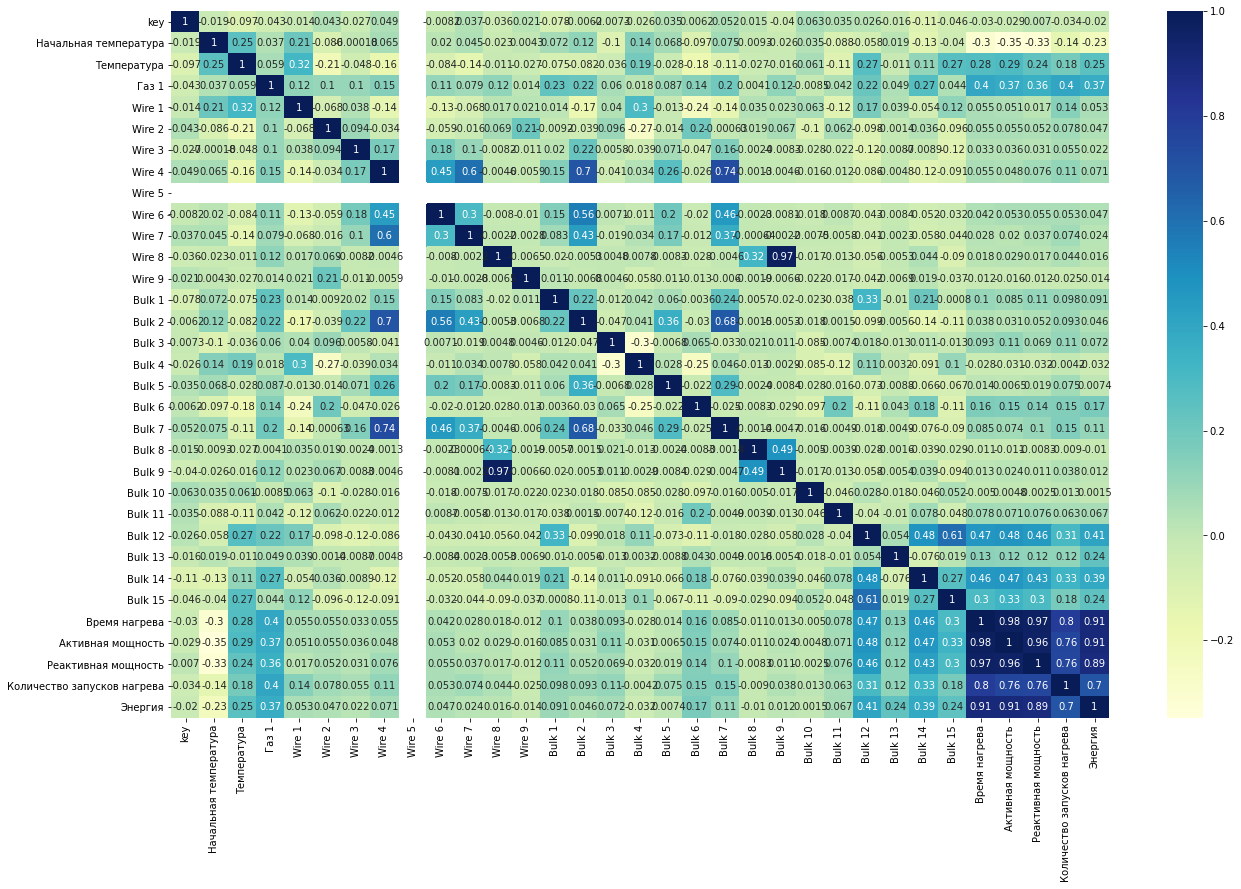

In [64]:
 
plt.figure(figsize=(21,13))                                  # подготавливаем размер рисунка, чтобы цифры не накладывались друг
# на друга
df_plot = sns.heatmap(df4.corr(), cmap="YlGnBu", annot=True) # строим хитмэп по корреляциям всех признаков 
plt.show()

**Вывод**

Построенный хитмеп, говорит о том, что некоторые признаки сильно скоррелированы и необходимо избавиться от мультиколлинеарности. К таким признакам относится группа ("Bulk 9" и "Wire 8") и группа ("Время нагрева","Активная мощность","Реактивная мощность", "Количество запусков нагрева", "Энергия"). Для того, чтобы понять, какие признаки убрать, нужно оценить важность признаков для модели. Это будет сделано в дальнейшем. 

In [65]:
df4 = df4.drop('Wire 5', axis = 1)

In [66]:
train, test = train_test_split(df4, test_size=0.25, random_state=9082022) # разбиваем данные на обучающую и тестовую выборки

In [67]:
features_train = train.drop(['key','Температура'], axis=1)
target_train = train['Температура']
features_test = test.drop(['key','Температура'], axis=1)
target_test = test['Температура']



In [68]:
df4

,key,Начальная температура,Температура,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,...,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Время нагрева,Активная мощность,Реактивная мощность,Количество запусков нагрева,Энергия
0,1,1571.0,1613.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,206.0,0.0,150.0,154.0,1098.0,4.878147,3.183241,5,5356.204921
1,2,1581.0,1602.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,206.0,0.0,149.0,154.0,811.0,3.052598,1.998112,4,2475.657040
2,3,1596.0,1599.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,205.0,0.0,152.0,153.0,655.0,2.525882,1.599076,5,1654.452851
3,4,1601.0,1625.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,207.0,0.0,153.0,154.0,741.0,3.209250,2.060298,4,2378.054308
4,5,1576.0,1602.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,203.0,0.0,151.0,152.0,869.0,3.347173,2.252643,4,2908.693106
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,256.0,0.0,129.0,223.0,723.0,3.210690,2.360777,4,2321.328989
2325,2496,1554.0,1591.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,256.0,0.0,129.0,226.0,940.0,4.203064,2.810185,6,3950.880562
2326,2497,1571.0,1589.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,230.0,0.0,124.0,226.0,569.0,2.212379,1.851269,3,1258.843787
2327,2498,1591.0,1594.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,...,0.0,206.0,0.0,129.0,207.0,750.0,3.408725,2.355428,5,2556.544116


### Модель случайного леса

In [69]:
model = RandomForestRegressor(random_state=9082022, n_estimators = 200)
predictions = pd.Series(cross_val_predict(model, features_train, target_train, cv=7))


In [70]:
model.fit(features_train, target_train)
model.feature_importances_                                                       # определяем важность всех признаков
importances = pd.DataFrame(data=model.feature_importances_, index=features_train.columns)
importances.rename(columns={0: 'Важность'}, inplace=True)
importances.sort_values(by='Важность')

,Важность
Bulk 8,0.000019
Wire 8,0.000094
Bulk 9,0.000177
Wire 9,0.000199
Bulk 13,0.000768
Bulk 5,0.001386
Bulk 2,0.001883
Wire 3,0.002238
Wire 7,0.002988
Bulk 11,0.004530


**Вывод**

Из признаков необходимо убрать те столбцы из групп коллинеарных векторов, что имеют наименьшую важность для модели.

In [75]:
train, test = train_test_split(df4.drop(['Wire 8', 'Количество запусков нагрева',
                                         'Реактивная мощность', 'Энергия','Время нагрева'],
                                        axis=1),
                               test_size=0.25, random_state=9082022) # разбиваем данные на обучающую и тестовую выборки
features_train = train.drop(['key','Температура'], axis=1)
target_train = train['Температура']
features_test = test.drop(['key','Температура'], axis=1)
target_test = test['Температура']

scaler = StandardScaler()                                #
scaler.fit(features_train)                               # определение параметров масштабирования

features_train_scaled = scaler.transform(features_train) # масштабирование признаков обучающей выборки
features_test_scaled = scaler.transform(features_test)   # масштабирование признаков тестовой выборки

model = RandomForestRegressor(random_state=9082022, n_estimators = 500, min_samples_leaf = 5)
predictions = pd.Series(cross_val_predict(model, features_train_scaled, target_train, cv=7))

In [76]:
MAE = mean_absolute_error(predictions,target_train)
print('Метрика MAE в модели случайного леса:', MAE)

Метрика MAE в модели случайного леса: 6.08526569191203


In [78]:
df4.drop(['Wire 8', 'Количество запусков нагрева',
                                         'Реактивная мощность', 'Энергия','Время нагрева'],
                                        axis=1)

,key,Начальная температура,Температура,Газ 1,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,...,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Активная мощность
0,1,1571.0,1613.0,29.749986,60.059998,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4.878147
1,2,1581.0,1602.0,12.555561,96.052315,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,3.052598
2,3,1596.0,1599.0,28.554793,91.160157,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,2.525882
3,4,1601.0,1625.0,18.841219,89.063515,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,3.209250
4,5,1576.0,1602.0,5.413692,89.238236,9.11456,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,3.347173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2324,2495,1570.0,1591.0,7.125735,89.150879,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,3.210690
2325,2496,1554.0,1591.0,9.412616,114.179527,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,4.203064
2326,2497,1571.0,1589.0,6.271699,94.086723,9.04800,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,2.212379
2327,2498,1591.0,1594.0,14.953657,118.110717,0.00000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,3.408725


### Простое заполнение средним

In [79]:
predictions_2 = target_train.mean() * np.ones(len(target_train))

In [80]:
MAE = mean_absolute_error(predictions_2,target_train)
print('Метрика MAE при простом заполнении средним:', MAE)

Метрика MAE при простом заполнении средним: 8.088532256350298


### Модель линейной регрессии

In [81]:
model_1 = LinearRegression()
predictions = pd.Series(cross_val_predict(model_1, features_train_scaled, target_train, cv=10))
MAE = mean_absolute_error(predictions,target_train)
print('Метрика MAE модели линейной регрессии:', MAE)

Метрика MAE модели линейной регрессии: 7.569628862191968


### Модель LGBM

In [82]:
model_LGBM = ltb.LGBMRegressor(random_state='12345', max_depth = 13)
predictions = pd.Series(cross_val_predict(model_LGBM, features_train_scaled, target_train, cv=7))
MAE = mean_absolute_error(predictions,target_train)
print('Метрика MAE в модели LGBM:', MAE)

Метрика MAE в модели LGBM: 6.182144513129203


**Вывод**

Лучшей моделью оказалась модель случайного леса.

### Тест лучшей модели

In [83]:
model.fit(features_train_scaled, target_train)
predictions = model.predict(features_test_scaled)
MAE = mean_absolute_error(predictions,target_test)
print('Метрика MAE модели случайного леса с количеством решателей 500 и минимальным числом элементов 5 в узле листа на тесте:',
      round(MAE,2))

Метрика MAE модели случайного леса с количеством решателей 500 и минимальным числом элементов 5 в узле листа на тесте: 6.03


## Отчёт



Чек-лист выполнения плана

- [x] Уточнение образовавшихся вопросов.
- [x] Предварительная обработка данных: удаление ненужных пропусков, неадекватных значений.
- [x] Подготовка датафрейма с признаками, которые объективно влияют на температуру расплава. Разбиение его на выборки (обучающую, валидационную и тестовую)
- [x] Определение модели МО с лучшей метрикой качества предсказания. 
- [x] Написание вывода и отчёта.


Все этапы плана были выполнены в ходе работы над проектом.

Самым трудным этапом для меня оказалось выделение признаков, которые могут влиять на целевой признак. Тут пришлось методом проб и ошибок создать датафрейм с множеством признаков, некоторые из которых, как оказалось, сильно скоррелированы, построить по данным модель, оценить важность признаков и избавиться от наименее важных коррелирующих признаков. Этот этап был самым долгим.

Первым делом был выполнен анализ имеющихся данных: удалены партии с неадектватными значениями физ. величин, удалены партии без целевого признака, удалены партии, где температура измерялась только 1 раз. Были построены диаграммы размаха, которые позволили оценить параметры распределений физ. величин. Также были заполнены пропуски в числовых значениях, а дата приведена к логичному формату datetime.

Следующим этапом стало создание сводной таблицы признаков по всем оставшимся партиям. В качестве признаков были взяты как уже данные величины (начальная температура, количество сыпучих материалов и т.д.), так и вычисленные (потраченная энергия, количество нагревов сплава и т.д.). Получился датафрейм из 2349 событий и 30 признаков. Далее была проведена проверка на мультиколлинеарность, в ходе которой выяснилось, что некоторые признаки очень скоррелированы.

Далее датафрейм был разбит на выборки, выделен целевой признак и признаки, проведено мастабирование признаков. По тестовой выборке построена модель случайного леса. Эта модель была обучена, а затем была определена степень важности всех признаков. Далее проведено избавление от мультиколлинеарности (избавлялись от наименее важных признаков).

После этого были построены модели:
- cлучайного леса MAE на обучающей выборке 6.08, 
- линейной регрессии MAE на обучающей выборке 7.57, 
- простого заполнения средним MAE на обучающей выборке 8.09,
- LGBM с макс. глубиной=13 показала MAE на обучающей выборке 6.18.

Итоговой моделью победителем стал случайный лес (RandomForestRegressor) при разбиении на обучающую и тестовую выборку в соотношении 3:1  (train_test_split(test_size=0.25, random_state=9082022)) В качестве признаков выступали: "Начальная температура", "Активная мощность", объём используемого инертного газа, количество добавленных сыпучих материалов № 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15; количество добавленной проволоки № 1, 2, 3, 4, 6, 7, 9  






Параметры модели:
- количество решателей 500
- минимальное числом элементов 5 в узле листа
- random_state=9082022

MAE на тестовой выборке составило 6.03. 

Что же касается признаков, которые оказывают существенное влияние на итоговую температуру, то это: 
- начальная температура
- активная мощность
- количество сыпучего материала №6

